In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("winequalityN.csv")

In [3]:
df.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


### Our hypothesises for solving classification problem with 7 classes(3, 4, 5, 6, 7, 8, 9)
1. We will use all features in modeling step (H1)

    -Fillna process with median strategy
    
    -StandardScaler process
    
    -OneHotEncoder process for categoric feature
    
2. We will drop 'free sulfur dioxide' and 'total sulfur dioxide' and will append new feature 'free sulfur dioxide'*'total sulfur dioxide' in modeling step (H2)

3. We will use all features in modeling step BUT...(H3)

    -Split data by 'type' column: red and white
    
    -Remove duplicates from dataset
    
    -Copy data without NaNs, and split by 'quality'
    
    -Remove outliers for each 'quality' dataset
    
    -Fill NaNs by mean/median values for each 'quality' dataset
    
    -Reconstract initial ordering of dataset and shuffle for modelling.

In [16]:
categoric_features = ['type']
numeric_features = ['alcohol', 'chlorides', 'citric acid', 'density', 'fixed acidity',
           'free sulfur dioxide', 'pH', 'residual sugar', 'sulphates',
           'total sulfur dioxide', 'volatile acidity']

### Now let's do some changes with our data

1.Make X features and y label

2.Fillna process (We have nulls only in numeric features and will use the MEDIAN strategy for not changing ditribution)

3.Scale process (We will use the StandardScaler strategy)

4.OneHotEncoder process for categoric feature

5.Spliting data for modeling step (X_train, X_test, y_train, y_test)

### We will use 4 models for classification problem(LogisticRegression, KNeighborsClassifier, RandomForestClassifier, svm)

In [17]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  precision_score, confusion_matrix, classification_report, multilabel_confusion_matrix

In [18]:
X = df[df.columns.difference(['quality'])]
y = df['quality']

In [19]:
df.columns.difference(['quality'])

Index(['alcohol', 'chlorides', 'citric acid', 'density', 'fixed acidity',
       'free sulfur dioxide', 'pH', 'residual sugar', 'sulphates',
       'total sulfur dioxide', 'type', 'volatile acidity'],
      dtype='object')

In [20]:
X.shape, y.shape

((6497, 12), (6497,))

In [21]:
def castom_StandardScaler_One_Hot_Encoder(X, numeric_features = [], categoric_features = []):
    """
    This function takes data, numeric_features[list] and categoric_features[list] and returns changed data.
    
    For numeric_features: Data -> Fillna(SimpleImputer(strategy='mean')) -> Scale(StandardScaler) -> Data
    
    For categoric_features: Data -> OneHotEncoder -> Data
    
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    import numpy as np
    import pandas as pd
    if numeric_features and categoric_features:
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median').fit(X[numeric_features])
        X[numeric_features] = imp_mean.transform(X[numeric_features])
        
        scale = StandardScaler().fit(X[numeric_features])
        newX = scale.transform(X[numeric_features])
        X_scaled = pd.DataFrame(newX, columns = numeric_features)
        X_hot = pd.get_dummies(X[categoric_features])
        
        return pd.concat([X_hot, X_scaled], axis = 1)
    
    elif numeric_features and not categoric_features:
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median').fit(X[numeric_features])
        X[numeric_features] = imp_mean.transform(X[numeric_features])
        
        scale = StandardScaler().fit(X[numeric_features])
        newX = scale.transform(X[numeric_features])
        X_scaled = pd.DataFrame(newX, columns = numeric_features)
        
        return pd.concat([X[X.columns.difference(numeric_features)], X_scaled], axis = 1)
    
    elif categoric_features and not numeric_features:
        X_hot = pd.get_dummies(X[categoric_features])
        
        return pd.concat([X[X.columns.difference(categoric_features)], X_hot], axis = 1) 
    
    return X
        
        

In [22]:
X = castom_StandardScaler_One_Hot_Encoder(X, numeric_features = numeric_features, categoric_features = categoric_features)

In [23]:
X.shape

(6497, 13)

In [24]:
X.head(2)

,type_red,type_white,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,0,1,-1.418558,-0.315139,0.284273,2.102214,-0.166898,0.815565,-1.359590,3.207005,-0.545868,0.959976,-0.423168
1,0,1,-0.831615,-0.200946,0.146551,-0.232332,-0.707155,-0.931107,0.508116,-0.807946,-0.276974,0.287618,-0.240846


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type_red              6497 non-null   uint8  
 1   type_white            6497 non-null   uint8  
 2   alcohol               6497 non-null   float64
 3   chlorides             6497 non-null   float64
 4   citric acid           6497 non-null   float64
 5   density               6497 non-null   float64
 6   fixed acidity         6497 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   residual sugar        6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  total sulfur dioxide  6497 non-null   float64
 12  volatile acidity      6497 non-null   float64
dtypes: float64(11), uint8(2)
memory usage: 571.2 KB


In [26]:
X.shape, y.shape

((6497, 13), (6497,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [28]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [29]:
def roc_aux_plot(model, X, y):
    
    """
    This  function takes model, X data and y label and returns ROC AUX metrics and draws for each classes
    """
    
    y = label_binarize(y, classes=[3, 4, 5, 6, 7, 8, 9])
    n_classes = y.shape[1]
    
    random_state = np.random.RandomState(0)
    n_samples, n_features = X.shape
    X = np.c_[X, random_state.randn(n_samples, n_features)]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0, stratify = y)
    
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    lw = 2
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'r', 'b', 'brown', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+3, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUX for multi-class by using {model}')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
score = 0
final_model = None
best_grid_search = None

In [31]:
# LogisticRegression
lr = LogisticRegression(random_state=1)
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, cv = 5)
grid_search_lr.fit(X_train, y_train)
if grid_search_lr.best_score_ > score:
    score = grid_search_lr.best_score_
    final_model = lr
    best_grid_search = grid_search_lr
pred_y_test_lr = grid_search_lr.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.54      0.61      0.58       428
           6       0.50      0.65      0.57       567
           7       0.42      0.15      0.22       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.51      1300
   macro avg       0.21      0.20      0.19      1300
weighted avg       0.47      0.51      0.47      1300

[[[1294    0]
  [   6    0]]

 [[1257    0]
  [  43    0]]

 [[ 651  221]
  [ 166  262]]

 [[ 363  370]
  [ 196  371]]

 [[1040   44]
  [ 184   32]]

 [[1261    0]
  [  39    0]]

 [[1299    0]
  [   1    0]]]
0.5482048197231065 0.5482048197231065


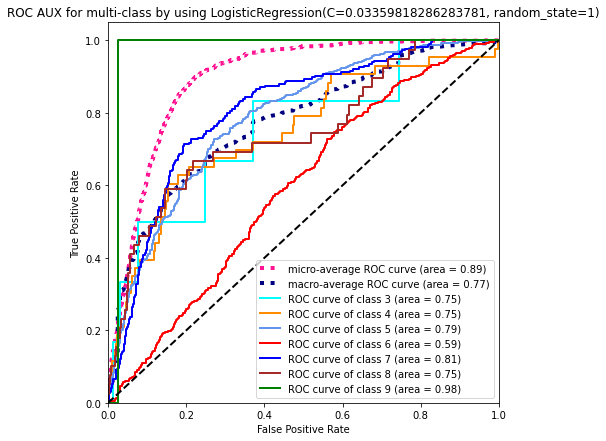

In [32]:
print(classification_report( y_test, pred_y_test_lr))
print(multilabel_confusion_matrix( y_test, pred_y_test_lr))
print(grid_search_lr.best_score_, score)
roc_aux_plot(grid_search_lr.best_estimator_, X, y)

In [33]:
# KNN
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(3, 30)}
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv = 5)
grid_search_knn.fit(X_train, y_train)
if grid_search_knn.best_score_ > score:
    score = grid_search_knn.best_score_
    final_model = knn
    best_grid_search = grid_search_knn
pred_y_test_knn = grid_search_knn.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.02      0.04        43
           5       0.57      0.67      0.62       428
           6       0.54      0.59      0.57       567
           7       0.50      0.37      0.42       216
           8       0.29      0.05      0.09        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.29      0.24      0.25      1300
weighted avg       0.52      0.54      0.52      1300

[[[1293    1]
  [   6    0]]

 [[1252    5]
  [  42    1]]

 [[ 652  220]
  [ 140  288]]

 [[ 452  281]
  [ 231  336]]

 [[1003   81]
  [ 136   80]]

 [[1256    5]
  [  37    2]]

 [[1299    0]
  [   1    0]]]
0.5483974975938403 0.5483974975938403


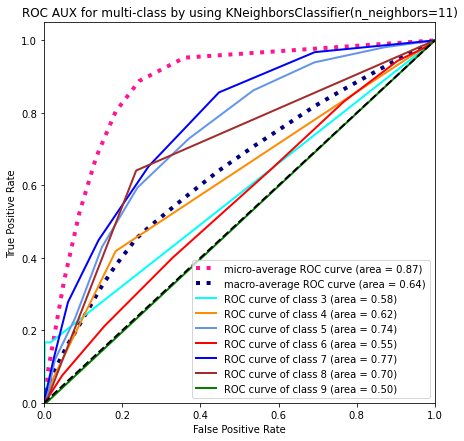

In [34]:
print(classification_report(y_test, pred_y_test_knn))
print(multilabel_confusion_matrix(y_test, pred_y_test_knn))
print(grid_search_knn.best_score_, score)
roc_aux_plot(grid_search_knn.best_estimator_, X, y)

In [35]:
# RandomForest
rf = RandomForestClassifier(n_estimators = 40, random_state=0)
param_grid_rf = {'max_depth': range(2, 9), 'min_samples_split': range(2, 11, 2)}
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv = 5)
grid_search_rf.fit(X_train, y_train)
if grid_search_rf.best_score_ > score:
    score = grid_search_rf.best_score_
    final_model = rf
    best_grid_search = grid_search_rf
pred_y_test_rf = grid_search_rf.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.05        43
           5       0.64      0.68      0.66       428
           6       0.57      0.76      0.65       567
           7       0.68      0.28      0.40       216
           8       1.00      0.05      0.10        39
           9       0.00      0.00      0.00         1

    accuracy                           0.61      1300
   macro avg       0.56      0.26      0.27      1300
weighted avg       0.64      0.61      0.57      1300

[[[1294    0]
  [   6    0]]

 [[1257    0]
  [  42    1]]

 [[ 707  165]
  [ 136  292]]

 [[ 414  319]
  [ 136  431]]

 [[1055   29]
  [ 155   61]]

 [[1261    0]
  [  37    2]]

 [[1299    0]
  [   1    0]]]
0.5918805064040868 0.5918805064040868


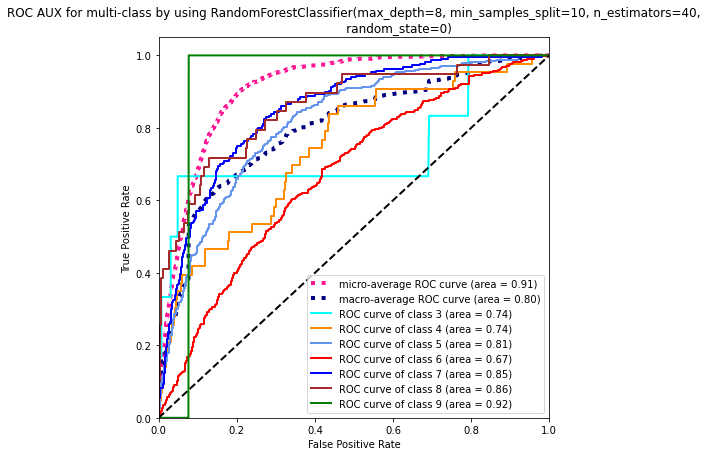

In [36]:
print(classification_report(y_test, pred_y_test_rf))
print(multilabel_confusion_matrix(y_test, pred_y_test_rf))
print(grid_search_rf.best_score_, score)
roc_aux_plot(grid_search_rf.best_estimator_, X, y)

In [37]:
# SVM
    svm_model = svm.SVC(random_state=0, probability=True)
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : np.arange(-1, 1, 0.2)}
grid_search_svm = GridSearchCV(svm_model, param_grid=param_grid_svm, cv = 5)
grid_search_svm.fit(X_train, y_train)
if grid_search_svm.best_score_ > score:
    score = grid_search_svm.best_score_
    final_model = svm_model
    best_grid_search = grid_search_svm
pred_y_test_svm = grid_search_svm.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.62      0.67      0.64       428
           6       0.54      0.73      0.62       567
           7       0.50      0.15      0.23       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1300
   macro avg       0.24      0.22      0.21      1300
weighted avg       0.52      0.56      0.52      1300

[[[1294    0]
  [   6    0]]

 [[1257    0]
  [  43    0]]

 [[ 694  178]
  [ 142  286]]

 [[ 377  356]
  [ 151  416]]

 [[1052   32]
  [ 184   32]]

 [[1261    0]
  [  39    0]]

 [[1299    0]
  [   1    0]]]
0.5668669948915377 0.5918805064040868


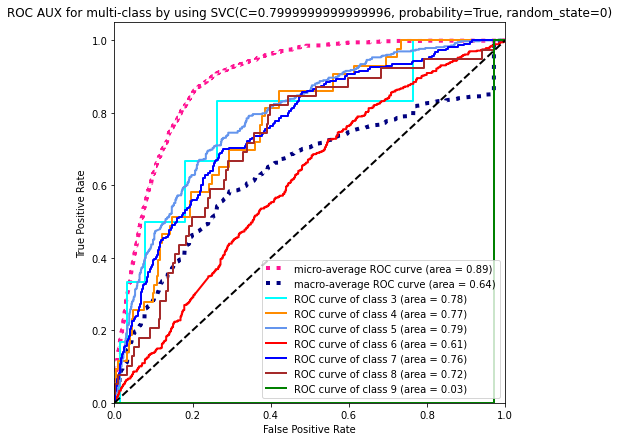

In [38]:
print(classification_report(y_test, pred_y_test_svm))
print(multilabel_confusion_matrix(y_test, pred_y_test_svm))
print(grid_search_svm.best_score_, score)
roc_aux_plot(grid_search_svm.best_estimator_, X, y)

In [39]:
print(score, final_model, best_grid_search)

0.5918805064040868 RandomForestClassifier(n_estimators=40, random_state=0) GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=40, random_state=0),
             param_grid={'max_depth': range(2, 9),
                         'min_samples_split': range(2, 11, 2)})


### As we can see the best model for this problem(Hipotesis H1) is RandomForestClassifier.It has the best score and best macro-average ROC curve.

In [40]:
best_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=40, random_state=0),
             param_grid={'max_depth': range(2, 9),
                         'min_samples_split': range(2, 11, 2)})

In [41]:
Y_predict_test = best_grid_search.best_estimator_.predict(X_test)

In [42]:
Y_predict_train = best_grid_search.best_estimator_.predict(X_train)

In [43]:
best_grid_search.score(X_train, y_train)

0.6790456032326342

In [44]:
best_grid_search.score(X_test, y_test)

0.6053846153846154

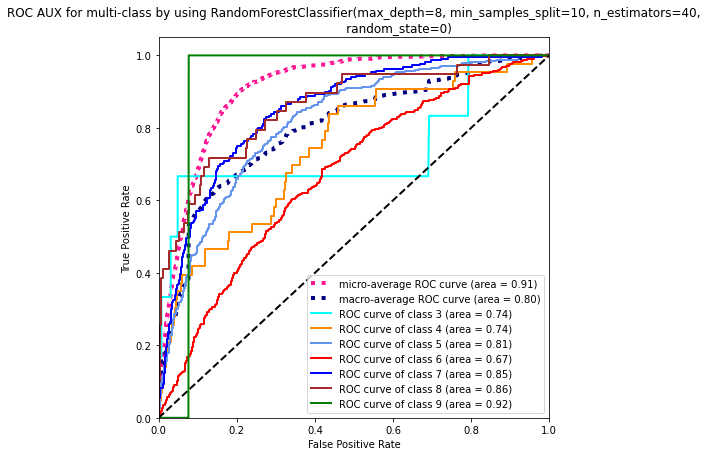

None


In [45]:
print(roc_aux_plot(best_grid_search.best_estimator_, X, y))

In [46]:
print(classification_report(Y_predict_test, y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.02      1.00      0.05         1
           5       0.68      0.64      0.66       457
           6       0.76      0.57      0.65       750
           7       0.28      0.68      0.40        90
           8       0.05      1.00      0.10         2
           9       0.00      0.00      0.00         0

    accuracy                           0.61      1300
   macro avg       0.26      0.56      0.27      1300
weighted avg       0.70      0.61      0.64      1300



In [47]:
print(classification_report(Y_predict_train, y_train))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.06      1.00      0.12        11
           5       0.74      0.73      0.74      1730
           6       0.83      0.63      0.72      2997
           7       0.41      0.79      0.54       451
           8       0.05      1.00      0.10         8
           9       0.00      0.00      0.00         0

    accuracy                           0.68      5197
   macro avg       0.30      0.59      0.32      5197
weighted avg       0.76      0.68      0.71      5197



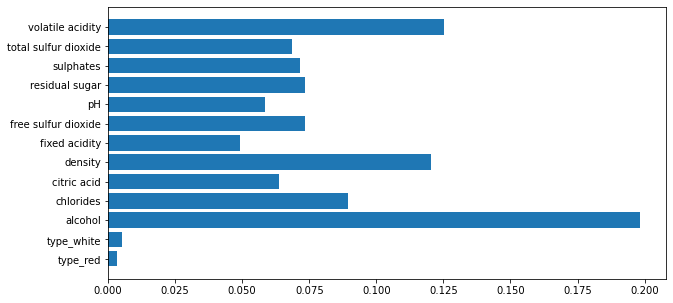

In [48]:
plt.figure(figsize=(10, 5))
plt.barh(X.columns, best_grid_search.best_estimator_.feature_importances_)
plt.show()

### As we can see from the feature importances graph the feature 'type' has the fewest importance in our model and we will drop it in our H2 hipotesis.

### Now let's fit our H2 hipotesis

In [49]:
new_X = df[df.columns.difference(['quality'])]
new_y = df['quality']

In [50]:
new_X.head(2)

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,type,volatile acidity
0,8.8,0.045,0.36,1.001,7.0,45.0,3.0,20.7,0.45,170.0,white,0.27
1,9.5,0.049,0.34,0.994,6.3,14.0,3.3,1.6,0.49,132.0,white,0.30


In [51]:
new_X.drop(new_X[['type']], axis=1, inplace=True)

In [52]:
new_X['free sulfur dioxide*total sulfur dioxide'] = new_X['free sulfur dioxide']*new_X['total sulfur dioxide']

In [53]:
new_X.drop(new_X[['free sulfur dioxide', 'total sulfur dioxide']], axis=1, inplace=True)

In [54]:
new_X.shape, new_y.shape

((6497, 10), (6497,))

In [55]:
new_X.head(2)

,alcohol,chlorides,citric acid,density,fixed acidity,pH,residual sugar,sulphates,volatile acidity,free sulfur dioxide*total sulfur dioxide
0,8.8,0.045,0.36,1.001,7.0,3.0,20.7,0.45,0.27,7650.0
1,9.5,0.049,0.34,0.994,6.3,3.3,1.6,0.49,0.30,1848.0


In [56]:
new_numeric_features = ['alcohol', 'chlorides', 'citric acid', 'density', 'fixed acidity', 'pH',
       'residual sugar', 'sulphates', 'volatile acidity',
       'free sulfur dioxide*total sulfur dioxide']

In [57]:
new_X = castom_StandardScaler_One_Hot_Encoder(new_X, numeric_features = new_numeric_features)

In [58]:
new_X.head(2)

,alcohol,chlorides,citric acid,density,fixed acidity,pH,residual sugar,sulphates,volatile acidity,free sulfur dioxide*total sulfur dioxide
0,-1.418558,-0.315139,0.284273,2.102214,-0.166898,-1.359590,3.207005,-0.545868,-0.423168,0.835634
1,-0.831615,-0.200946,0.146551,-0.232332,-0.707155,0.508116,-0.807946,-0.276974,-0.240846,-0.592994


In [59]:
new_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   alcohol                                   6497 non-null   float64
 1   chlorides                                 6497 non-null   float64
 2   citric acid                               6497 non-null   float64
 3   density                                   6497 non-null   float64
 4   fixed acidity                             6497 non-null   float64
 5   pH                                        6497 non-null   float64
 6   residual sugar                            6497 non-null   float64
 7   sulphates                                 6497 non-null   float64
 8   volatile acidity                          6497 non-null   float64
 9   free sulfur dioxide*total sulfur dioxide  6497 non-null   float64
dtypes: float64(10)
memory usage: 507.7 K

In [60]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size = 0.2, random_state = 1, stratify = new_y)

In [61]:
new_score = 0
new_final_model = None
new_best_grid_search = None

In [62]:
# LogisticRegression
lr = LogisticRegression(random_state=1)
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, cv = 5)
grid_search_lr.fit(new_X_train, new_y_train)
if grid_search_lr.best_score_ > new_score:
    new_score = grid_search_lr.best_score_
    new_final_model = lr
    new_best_grid_search = grid_search_lr
pred_y_test_lr = grid_search_lr.best_estimator_.predict(new_X_test)

              precision    recall  f1-score   support

           3       0.50      0.17      0.25         6
           4       0.00      0.00      0.00        43
           5       0.54      0.59      0.56       428
           6       0.49      0.64      0.56       567
           7       0.46      0.20      0.28       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.51      1300
   macro avg       0.29      0.23      0.24      1300
weighted avg       0.47      0.51      0.48      1300

[[[1293    1]
  [   5    1]]

 [[1257    0]
  [  43    0]]

 [[ 658  214]
  [ 176  252]]

 [[ 359  374]
  [ 202  365]]

 [[1034   50]
  [ 173   43]]

 [[1261    0]
  [  39    0]]

 [[1299    0]
  [   1    0]]]
0.5468568149848227 0.5468568149848227


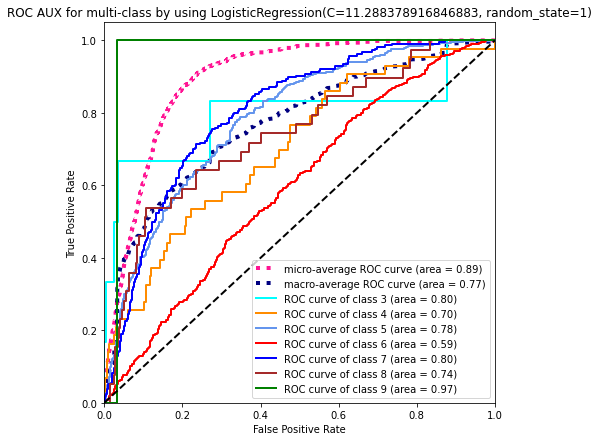

In [63]:
print(classification_report( new_y_test, pred_y_test_lr))
print(multilabel_confusion_matrix( new_y_test, pred_y_test_lr))
print(grid_search_lr.best_score_, new_score)
roc_aux_plot(grid_search_lr.best_estimator_, new_X, new_y)

In [64]:
# KNN
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(3, 30)}
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv = 5)
grid_search_knn.fit(new_X_train, new_y_train)
if grid_search_knn.best_score_ > new_score:
    new_score = grid_search_knn.best_score_
    new_final_model = knn
    new_best_grid_search = grid_search_knn
pred_y_test_knn = grid_search_knn.best_estimator_.predict(new_X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.14      0.16      0.15        43
           5       0.58      0.66      0.62       428
           6       0.58      0.59      0.59       567
           7       0.56      0.43      0.49       216
           8       0.48      0.26      0.33        39
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1300
   macro avg       0.33      0.30      0.31      1300
weighted avg       0.56      0.56      0.56      1300

[[[1290    4]
  [   6    0]]

 [[1213   44]
  [  36    7]]

 [[ 669  203]
  [ 146  282]]

 [[ 495  238]
  [ 232  335]]

 [[1011   73]
  [ 123   93]]

 [[1250   11]
  [  29   10]]

 [[1299    0]
  [   1    0]]]
0.5468599615014437 0.5468599615014437


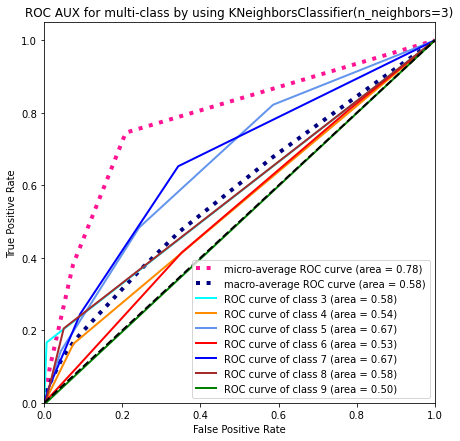

In [65]:
print(classification_report(new_y_test, pred_y_test_knn))
print(multilabel_confusion_matrix(new_y_test, pred_y_test_knn))
print(grid_search_knn.best_score_, new_score)
roc_aux_plot(grid_search_knn.best_estimator_, new_X, new_y)

In [66]:
# RandomForest
rf = RandomForestClassifier(n_estimators = 40, random_state=0)
param_grid_rf = {'max_depth': range(2, 9), 'min_samples_split': range(2, 11, 2)}
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv = 5)
grid_search_rf.fit(new_X_train, new_y_train)
if grid_search_rf.best_score_ > new_score:
    new_score = grid_search_rf.best_score_
    new_final_model = rf
    new_best_grid_search = grid_search_rf
pred_y_test_rf = grid_search_rf.best_estimator_.predict(new_X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.05        43
           5       0.65      0.67      0.66       428
           6       0.57      0.76      0.65       567
           7       0.63      0.30      0.41       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.60      1300
   macro avg       0.41      0.25      0.25      1300
weighted avg       0.60      0.60      0.57      1300

[[[1294    0]
  [   6    0]]

 [[1257    0]
  [  42    1]]

 [[ 719  153]
  [ 142  286]]

 [[ 406  327]
  [ 137  430]]

 [[1046   38]
  [ 151   65]]

 [[1261    0]
  [  39    0]]

 [[1299    0]
  [   1    0]]]
0.5897658621455542 0.5897658621455542


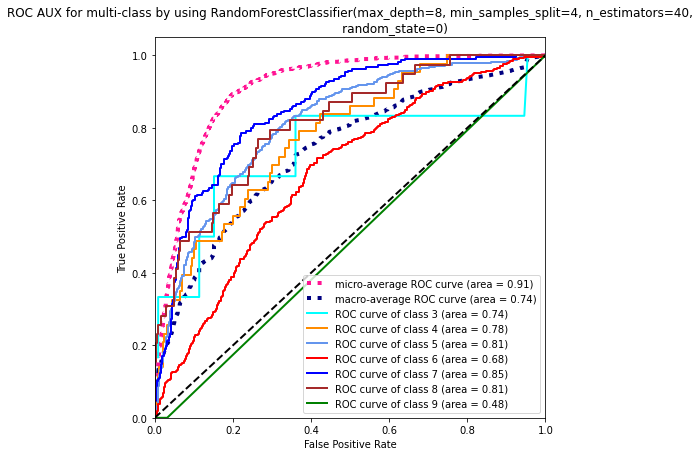

In [67]:
print(classification_report(new_y_test, pred_y_test_rf))
print(multilabel_confusion_matrix(new_y_test, pred_y_test_rf))
print(grid_search_rf.best_score_, new_score)
roc_aux_plot(grid_search_rf.best_estimator_, new_X, new_y)

In [68]:
# SVM
svm_model = svm.SVC(random_state=0, probability=True)
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : np.arange(-1, 1, 0.2)}
grid_search_svm = GridSearchCV(svm_model, param_grid=param_grid_svm, cv = 5)
grid_search_svm.fit(new_X_train, new_y_train)
if grid_search_svm.best_score_ > new_score:
    new_score = grid_search_svm.best_score_
    new_final_model = svm_model
    new_best_grid_search = grid_search_svm
pred_y_test_svm = grid_search_svm.best_estimator_.predict(new_X_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.60      0.65      0.62       428
           6       0.53      0.72      0.61       567
           7       0.52      0.16      0.24       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1300
   macro avg       0.24      0.22      0.21      1300
weighted avg       0.52      0.56      0.51      1300

[[[1294    0]
  [   6    0]]

 [[1257    0]
  [  43    0]]

 [[ 690  182]
  [ 151  277]]

 [[ 368  365]
  [ 156  411]]

 [[1053   31]
  [ 182   34]]

 [[1261    0]
  [  39    0]]

 [[1299    0]
  [   1    0]]]
0.5585920263567039 0.5897658621455542


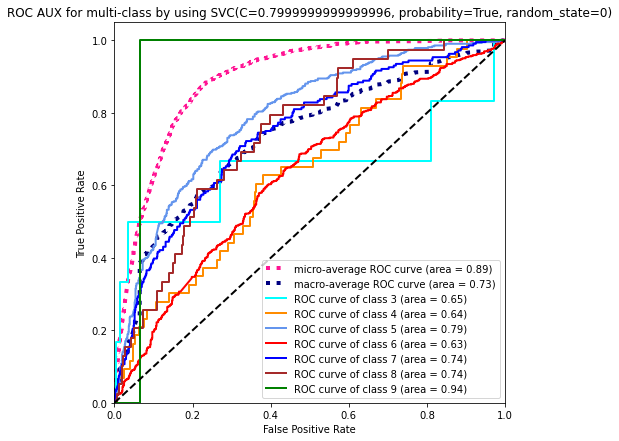

In [69]:
print(classification_report(new_y_test, pred_y_test_svm))
print(multilabel_confusion_matrix(new_y_test, pred_y_test_svm))
print(grid_search_svm.best_score_, new_score)
roc_aux_plot(grid_search_svm.best_estimator_, new_X, new_y)

In [70]:
print(new_score, score)

0.5897658621455542 0.5918805064040868


### Now let's fit our H3 hipotesis

In [71]:
data = df[:]

### Here is some functions that removes duplicates from DataSet and filling missing values.

In [72]:
def remove_duplicates(data):
    """
    This function removes duplicates from dataset 
    :return : returns new data
    """

    print('There are', str(data.duplicated().sum()), 'duplicated records.')
    new = data.drop_duplicates()
    print('There were', f'{(1-new.shape[0]/data.shape[0])*100:.2f}', '% duplicates in dataset. It was removed.')

    return new

def fill_missing(data, method = 'median'):
    '''
    This function fill NaNs with means by each type and quality
    :return: data
    '''
    main_features = data.columns.difference(['type', 'quality'])
    print('Here is the missing values for each column.')
    print(data.isna().sum())
    for color, df_by_type in data.groupby('type'):
        for category, df_by_quality in df_by_type.groupby('quality'):
            median = df_by_quality[main_features].median()
            mean = df_by_quality[main_features].mean()
            data[(data['type'] == color) & (data['quality'] == category)] = data[
                (data['type'] == color) & (data['quality'] == category)].fillna(median if method == 'median' else mean)

    return data

In [73]:
print(data.shape)

# Removing duplicates from dataset
data = remove_duplicates(data)
data.info()

# Filling NaNs by medians of each quality for each type of wine
# For example If wine is red and has quality value 3, missing value is equal the median of all 3rd red wines.
data = fill_missing(data)
data.info()

(6497, 13)
There are 1168 duplicated records.
There were 17.98 % duplicates in dataset. It was removed.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5329 non-null   object 
 1   fixed acidity         5319 non-null   float64
 2   volatile acidity      5321 non-null   float64
 3   citric acid           5326 non-null   float64
 4   residual sugar        5327 non-null   float64
 5   chlorides             5327 non-null   float64
 6   free sulfur dioxide   5329 non-null   float64
 7   total sulfur dioxide  5329 non-null   float64
 8   density               5329 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5325 non-null   float64
 11  alcohol               5329 non-null   float64
 12  quality               5329 non-null   int64  
dtypes: float64(11), int

In [74]:
data.head(2)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


In [75]:
data.shape

(5329, 13)

In [76]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['type']=le.fit_transform(data['type'])
new_X_2 = data[data.columns.difference(['quality'])]
new_y_2 = data['quality']

In [77]:
new_X_train_2, new_X_test_2, new_y_train_2, new_y_test_2 = train_test_split(new_X_2, new_y_2, test_size = 0.2, random_state = 1, stratify = new_y_2)

In [78]:
new_X_train_2.shape, new_X_test_2.shape, new_y_train_2.shape, new_y_test_2.shape

((4263, 12), (1066, 12), (4263,), (1066,))

In [79]:
new_X_train_2.head(2)

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,type,volatile acidity
3147,10.4,0.038,0.4,0.99568,7.2,45.0,3.2,8.7,0.47,154.0,1,0.32
6138,9.3,0.076,0.2,0.99494,7.5,36.0,3.1,1.7,0.40,60.0,0,0.61


In [80]:
sc = StandardScaler()
new_X_train_2 = sc.fit_transform(new_X_train_2)
new_X_test_2 = sc.fit_transform(new_X_test_2)

In [81]:
new_X_train_2.shape, new_X_test_2.shape, new_y_train_2.shape, new_y_test_2.shape

((4263, 12), (1066, 12), (4263,), (1066,))

In [82]:
new_score_2 = 0
new_final_model_2 = None
new_best_grid_search_2 = None

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.05      0.09        41
           5       0.57      0.59      0.58       351
           6       0.51      0.70      0.59       466
           7       0.45      0.15      0.22       171
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1066
   macro avg       0.36      0.21      0.21      1066
weighted avg       0.52      0.53      0.49      1066

[[[1060    0]
  [   6    0]]

 [[1025    0]
  [  39    2]]

 [[ 558  157]
  [ 145  206]]

 [[ 284  316]
  [ 138  328]]

 [[ 864   31]
  [ 146   25]]

 [[1035    1]
  [  30    0]]

 [[1065    0]
  [   1    0]]]
0.5493777829147609 0.5493777829147609


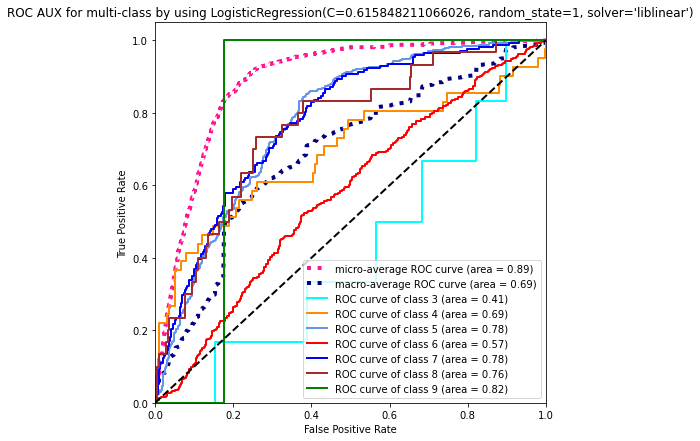

In [83]:
# LogisticRegression
lr_H3 = LogisticRegression(random_state=1, solver='liblinear')
param_grid_lr_H3 = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
grid_search_lr_H3 = GridSearchCV(lr_H3, param_grid=param_grid_lr_H3, cv = 5)
grid_search_lr_H3.fit(new_X_train_2, new_y_train_2)
if grid_search_lr_H3.best_score_ > new_score_2:
    new_score_2 = grid_search_lr_H3.best_score_
    new_final_model_2 = lr_H3
    new_best_grid_search_2 = grid_search_lr_H3
pred_y_test_lr = grid_search_lr_H3.best_estimator_.predict(new_X_test_2)

print(classification_report( new_y_test_2, pred_y_test_lr))
print(multilabel_confusion_matrix( new_y_test_2, pred_y_test_lr))
print(grid_search_lr_H3.best_score_, new_score_2)
roc_aux_plot(grid_search_lr_H3.best_estimator_, new_X_2, new_y_2)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        41
           5       0.56      0.57      0.56       351
           6       0.51      0.68      0.58       466
           7       0.45      0.23      0.30       171
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00         1

    accuracy                           0.52      1066
   macro avg       0.22      0.21      0.21      1066
weighted avg       0.48      0.52      0.49      1066

[[[1060    0]
  [   6    0]]

 [[1024    1]
  [  41    0]]

 [[ 558  157]
  [ 152  199]]

 [[ 294  306]
  [ 150  316]]

 [[ 847   48]
  [ 132   39]]

 [[1036    0]
  [  30    0]]

 [[1065    0]
  [   1    0]]]
0.5423473628012703 0.5493777829147609


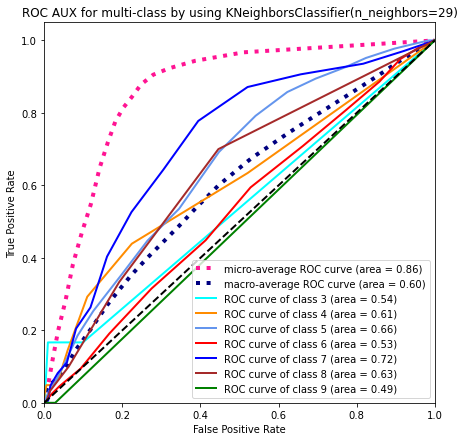

In [84]:
# KNN
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(3, 30)}
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv = 5)
grid_search_knn.fit(new_X_train_2, new_y_train_2)
if grid_search_knn.best_score_ > new_score_2:
    new_score_2 = grid_search_knn.best_score_
    new_final_model_2 = knn
    new_best_grid_search_2 = grid_search_knn
pred_y_test_knn = grid_search_knn.best_estimator_.predict(new_X_test_2)

print(classification_report(new_y_test_2, pred_y_test_knn))
print(multilabel_confusion_matrix(new_y_test_2, pred_y_test_knn))
print(grid_search_knn.best_score_, new_score_2)
roc_aux_plot(grid_search_knn.best_estimator_, new_X_2, new_y_2)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        41
           5       0.59      0.58      0.58       351
           6       0.51      0.70      0.59       466
           7       0.44      0.22      0.29       171
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1066
   macro avg       0.22      0.21      0.21      1066
weighted avg       0.49      0.53      0.50      1066

[[[1060    0]
  [   6    0]]

 [[1025    0]
  [  41    0]]

 [[ 574  141]
  [ 148  203]]

 [[ 291  309]
  [ 138  328]]

 [[ 847   48]
  [ 134   37]]

 [[1036    0]
  [  30    0]]

 [[1065    0]
  [   1    0]]]
0.5674418924645961 0.5674418924645961


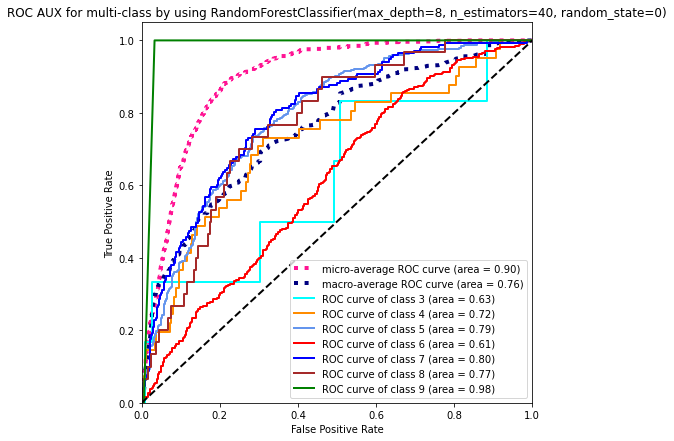

In [85]:
# RandomForest
rf = RandomForestClassifier(n_estimators = 40, random_state=0)
param_grid_rf = {'max_depth': range(2, 9), 'min_samples_split': range(2, 11, 2)}
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv = 5)
grid_search_rf.fit(new_X_train_2, new_y_train_2)
if grid_search_rf.best_score_ > new_score_2:
    new_score_2 = grid_search_rf.best_score_
    new_final_model_2 = rf
    new_best_grid_search_2 = grid_search_rf
pred_y_test_rf = grid_search_rf.best_estimator_.predict(new_X_test_2)

print(classification_report(new_y_test_2, pred_y_test_rf))
print(multilabel_confusion_matrix(new_y_test_2, pred_y_test_rf))
print(grid_search_rf.best_score_, new_score_2)
roc_aux_plot(grid_search_rf.best_estimator_, new_X_2, new_y_2)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        41
           5       0.59      0.60      0.59       351
           6       0.53      0.73      0.61       466
           7       0.50      0.18      0.26       171
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1066
   macro avg       0.23      0.22      0.21      1066
weighted avg       0.50      0.55      0.50      1066

[[[1060    0]
  [   6    0]]

 [[1025    0]
  [  41    0]]

 [[ 565  150]
  [ 139  212]]

 [[ 295  305]
  [ 127  339]]

 [[ 865   30]
  [ 141   30]]

 [[1036    0]
  [  30    0]]

 [[1065    0]
  [   1    0]]]
0.5604045924629449 0.5674418924645961


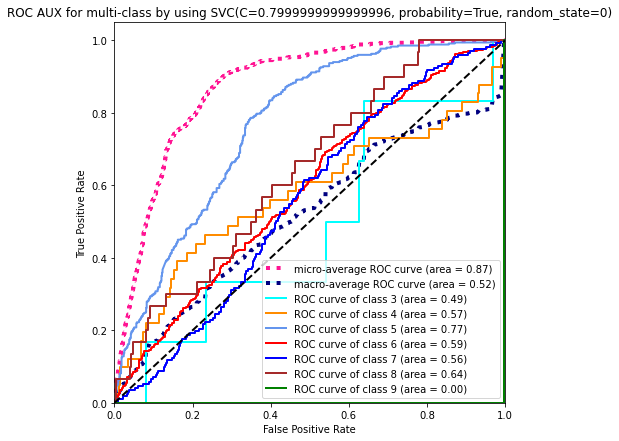

In [86]:
# SVM
svm_model = svm.SVC(random_state=0, probability=True)
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : np.arange(-1, 1, 0.2)}
grid_search_svm = GridSearchCV(svm_model, param_grid=param_grid_svm, cv = 5)
grid_search_svm.fit(new_X_train_2, new_y_train_2)
if grid_search_svm.best_score_ > new_score_2:
    new_score_2 = grid_search_svm.best_score_
    new_final_model_2 = svm_model
    new_best_grid_search_2 = grid_search_svm
pred_y_test_svm = grid_search_svm.best_estimator_.predict(new_X_test_2)

print(classification_report(new_y_test_2, pred_y_test_svm))
print(multilabel_confusion_matrix(new_y_test_2, pred_y_test_svm))
print(grid_search_svm.best_score_, new_score_2)
roc_aux_plot(grid_search_svm.best_estimator_, new_X_2, new_y_2)

In [87]:
print(f'Our scores are: H1: {np.round(score, 4)}, H2: {np.round(new_score, 4)}, H3: {np.round(new_score_2, 4)}')

Our scores are: H1: 0.5919, H2: 0.5898, H3: 0.5674


### Now we can say that our H1 hipotesis is more effective and we will use it.Let's also tune the number of n_estimators in our model.

In [88]:
best_grid_search

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=40, random_state=0),
             param_grid={'max_depth': range(2, 9),
                         'min_samples_split': range(2, 11, 2)})

In [89]:
best_grid_search.best_params_

{'max_depth': 8, 'min_samples_split': 10}

In [90]:
X_test.head(2)

,type_red,type_white,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
4328,0,1,0.409350,-0.372236,-0.886363,-0.122275,-0.629975,-0.142287,0.072318,0.810647,-0.008081,0.517635,0.488441
1275,0,1,-1.083162,0.227279,-0.335476,-0.299033,-0.784334,-0.593041,0.010062,-0.828966,-0.478645,0.287618,-0.727038


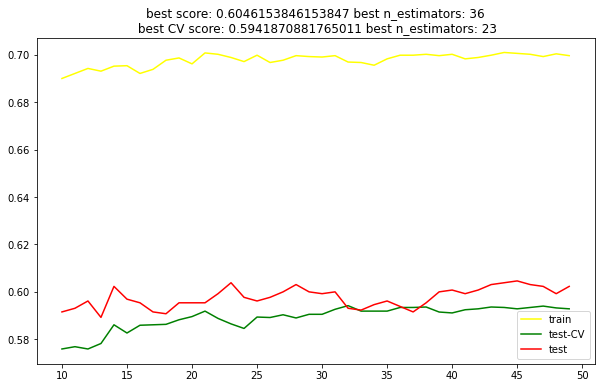

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score

n_estimators = range(10,50)

recall_cv = []
recall_test = []
recall_train = []

for i in n_estimators:
    rfc = RandomForestClassifier(n_estimators=i, max_depth = 8, min_samples_split = 2, random_state=0).fit(X_train,y_train)    
    recall_cv.append(np.mean(cross_val_score(rfc, X_train, y_train, scoring='recall_weighted', cv=5)))
    recall_test.append(recall_score(rfc.predict(X_test), y_test, average='weighted'))
    recall_train.append(recall_score(rfc.predict(X_train),y_train, average='weighted'))
    
plt.figure(figsize=(10, 6))    
plt.plot(n_estimators, recall_train, "yellow", label="train")
plt.plot(n_estimators, recall_cv, "green", label="test-CV")
plt.plot(n_estimators, recall_test, "red", label="test")
plt.title(f"best score: {max(recall_test)} best n_estimators: {np.argmax(recall_test)+1}\n best CV score: {max(recall_cv)} best n_estimators: {np.argmax(recall_cv)+1}")
plt.legend()
plt.show()

In [92]:
model = RandomForestClassifier(n_estimators=31, max_depth = 8, min_samples_split = 2, random_state=0).fit(X_train,y_train)

In [93]:
y_pred_test = model.predict(X_test)

In [94]:
y_pred_train = model.predict(X_train)

In [95]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       1.00      0.05      0.09        43
           5       0.64      0.68      0.66       428
           6       0.57      0.74      0.64       567
           7       0.67      0.31      0.42       216
           8       1.00      0.03      0.05        39
           9       0.00      0.00      0.00         1

    accuracy                           0.60      1300
   macro avg       0.55      0.26      0.27      1300
weighted avg       0.63      0.60      0.57      1300



In [96]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           3       1.00      0.04      0.08        24
           4       1.00      0.13      0.23       173
           5       0.75      0.75      0.75      1710
           6       0.65      0.85      0.74      2269
           7       0.82      0.45      0.58       863
           8       1.00      0.05      0.10       154
           9       0.00      0.00      0.00         4

    accuracy                           0.70      5197
   macro avg       0.75      0.32      0.35      5197
weighted avg       0.73      0.70      0.68      5197



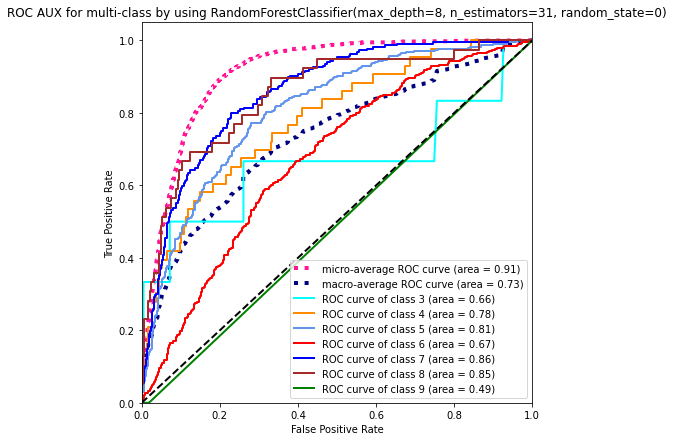

In [97]:
roc_aux_plot(model, X, y)

### Let's also check the model's dependance from the numbers of elements of our data

In [98]:
from sklearn.model_selection import learning_curve

In [99]:
def plot_learning_curve(model, X, y):
    """
    This function takes model, data and label and returns the graph of learning curve 
    for each class for training and validation set
    
    """
    N_train, val_train, val_test = learning_curve(model,
    X, y, train_sizes = np.linspace(0.05, 1, 20))
    
    plt.figure(figsize=(10, 10))
    plt.plot(N_train, val_train, label='training scores')
    plt.plot(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()


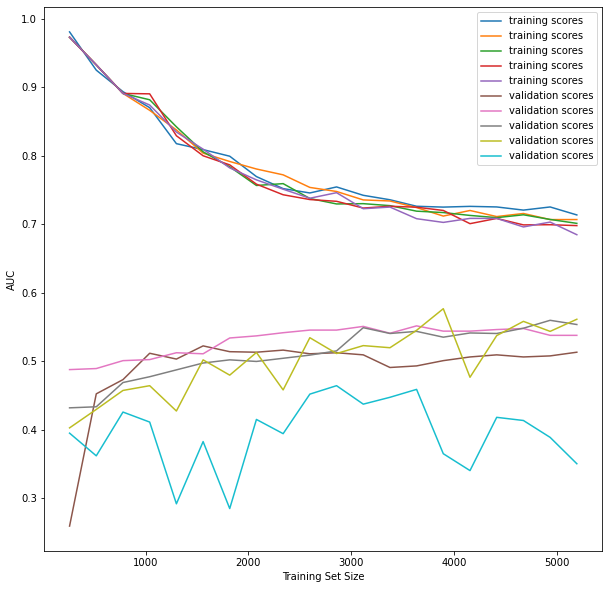

In [100]:
plot_learning_curve(model, X, y)

### We can conclude that the new data with more elements will not change the quality of our model